In [1]:
import os
import gc
import random

import torch

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim

import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm#_notebook as tqdm

from experiment import experiment, load_experiment
from experimentUtils import get_model_called, get_loss_function_called, get_optimizer_called, get_transform_called

from utils import check_memory_usage, start_timer, tick, count_parameters

import matplotlib
import matplotlib.pyplot as plt

#%matplotlib nbagg
#%matplotlib inline

cuda = torch.cuda.is_available()

#%env CUDA_LAUNCH_BLOCKING=1

In [2]:
ex = load_experiment('experiments/0.71_0.71_melo_7863389601_2019-06-24_VariationalAutoEncoderGMM_V_2g.pth.tar')

=> loading checkpoint 'experiments/0.71_0.71_melo_7863389601_2019-06-24_VariationalAutoEncoderGMM_V_2g.pth.tar'
{'modelName': 'VariationalAutoEncoderGMM', 'modelParams': {'imgSize': (160, 240), 'hidden_features': 500, 'latent_features': 30, 'in_channels': 3, 'num_samples': 10, 'cuda': True, 'n_gaussians': 2, 'min_mu': -3, 'max_mu': 3, 'sigma': 1}, 'loss': 'melo', 'opt': 'adam', 'optParams': {'lr': 5e-05}, 'imgSize': (240, 160), 'batchSize': 7, 'earlyStopping': 30, 'max_num_epochs': 300, 'cuda': True, 'denoise': False, 'datagetter_name': 'butterfly', 'datagetterParams': {'background': 'neutral', 'dataFilePath': '/home/rob/Dropbox/thesis/2. code/src/data/data.xlsx', 'root': '/home/rob/Dropbox/thesis/2. code/datasets', 'classifier_column': 'Sex', 'transforms': [('resize', {'size': (160, 240)}), 'hflip', ('rotateandscale', {'rotation': 1, 'scaling': 0.1, 'background': 'neutral'}), 'totensor'], 'sides': 'V'}}
Prepping Experiment..
Prepping Experiment..
=> loading checkpoint 'experiments/0.7

Running Experiment with Configuration: 
{'batchSize': 7,
 'cuda': True,
 'datagetterParams': {'background': 'neutral',
                      'classifier_column': 'Sex',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/data.xlsx',
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets',
                      'sides': 'V',
                      'transforms': [('resize', {'size': (160, 240)}),
                                     'hflip',
                                     ('rotateandscale',
                                      {'background': 'neutral',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'totensor']},
 'datagetter_name': 'butterfly',
 'denoise': False,
 'earlyStopping': 30,
 'imgSize': (240, 160),
 'loss': 'melo',
 'max_num_epochs': 1,
 'modelName': 'VariationalAutoEncoderGMM',
 'model


No classifier improvement, stopping after 138 epochs
tensor(0.8039, grad_fn=<NllLossBackward>)


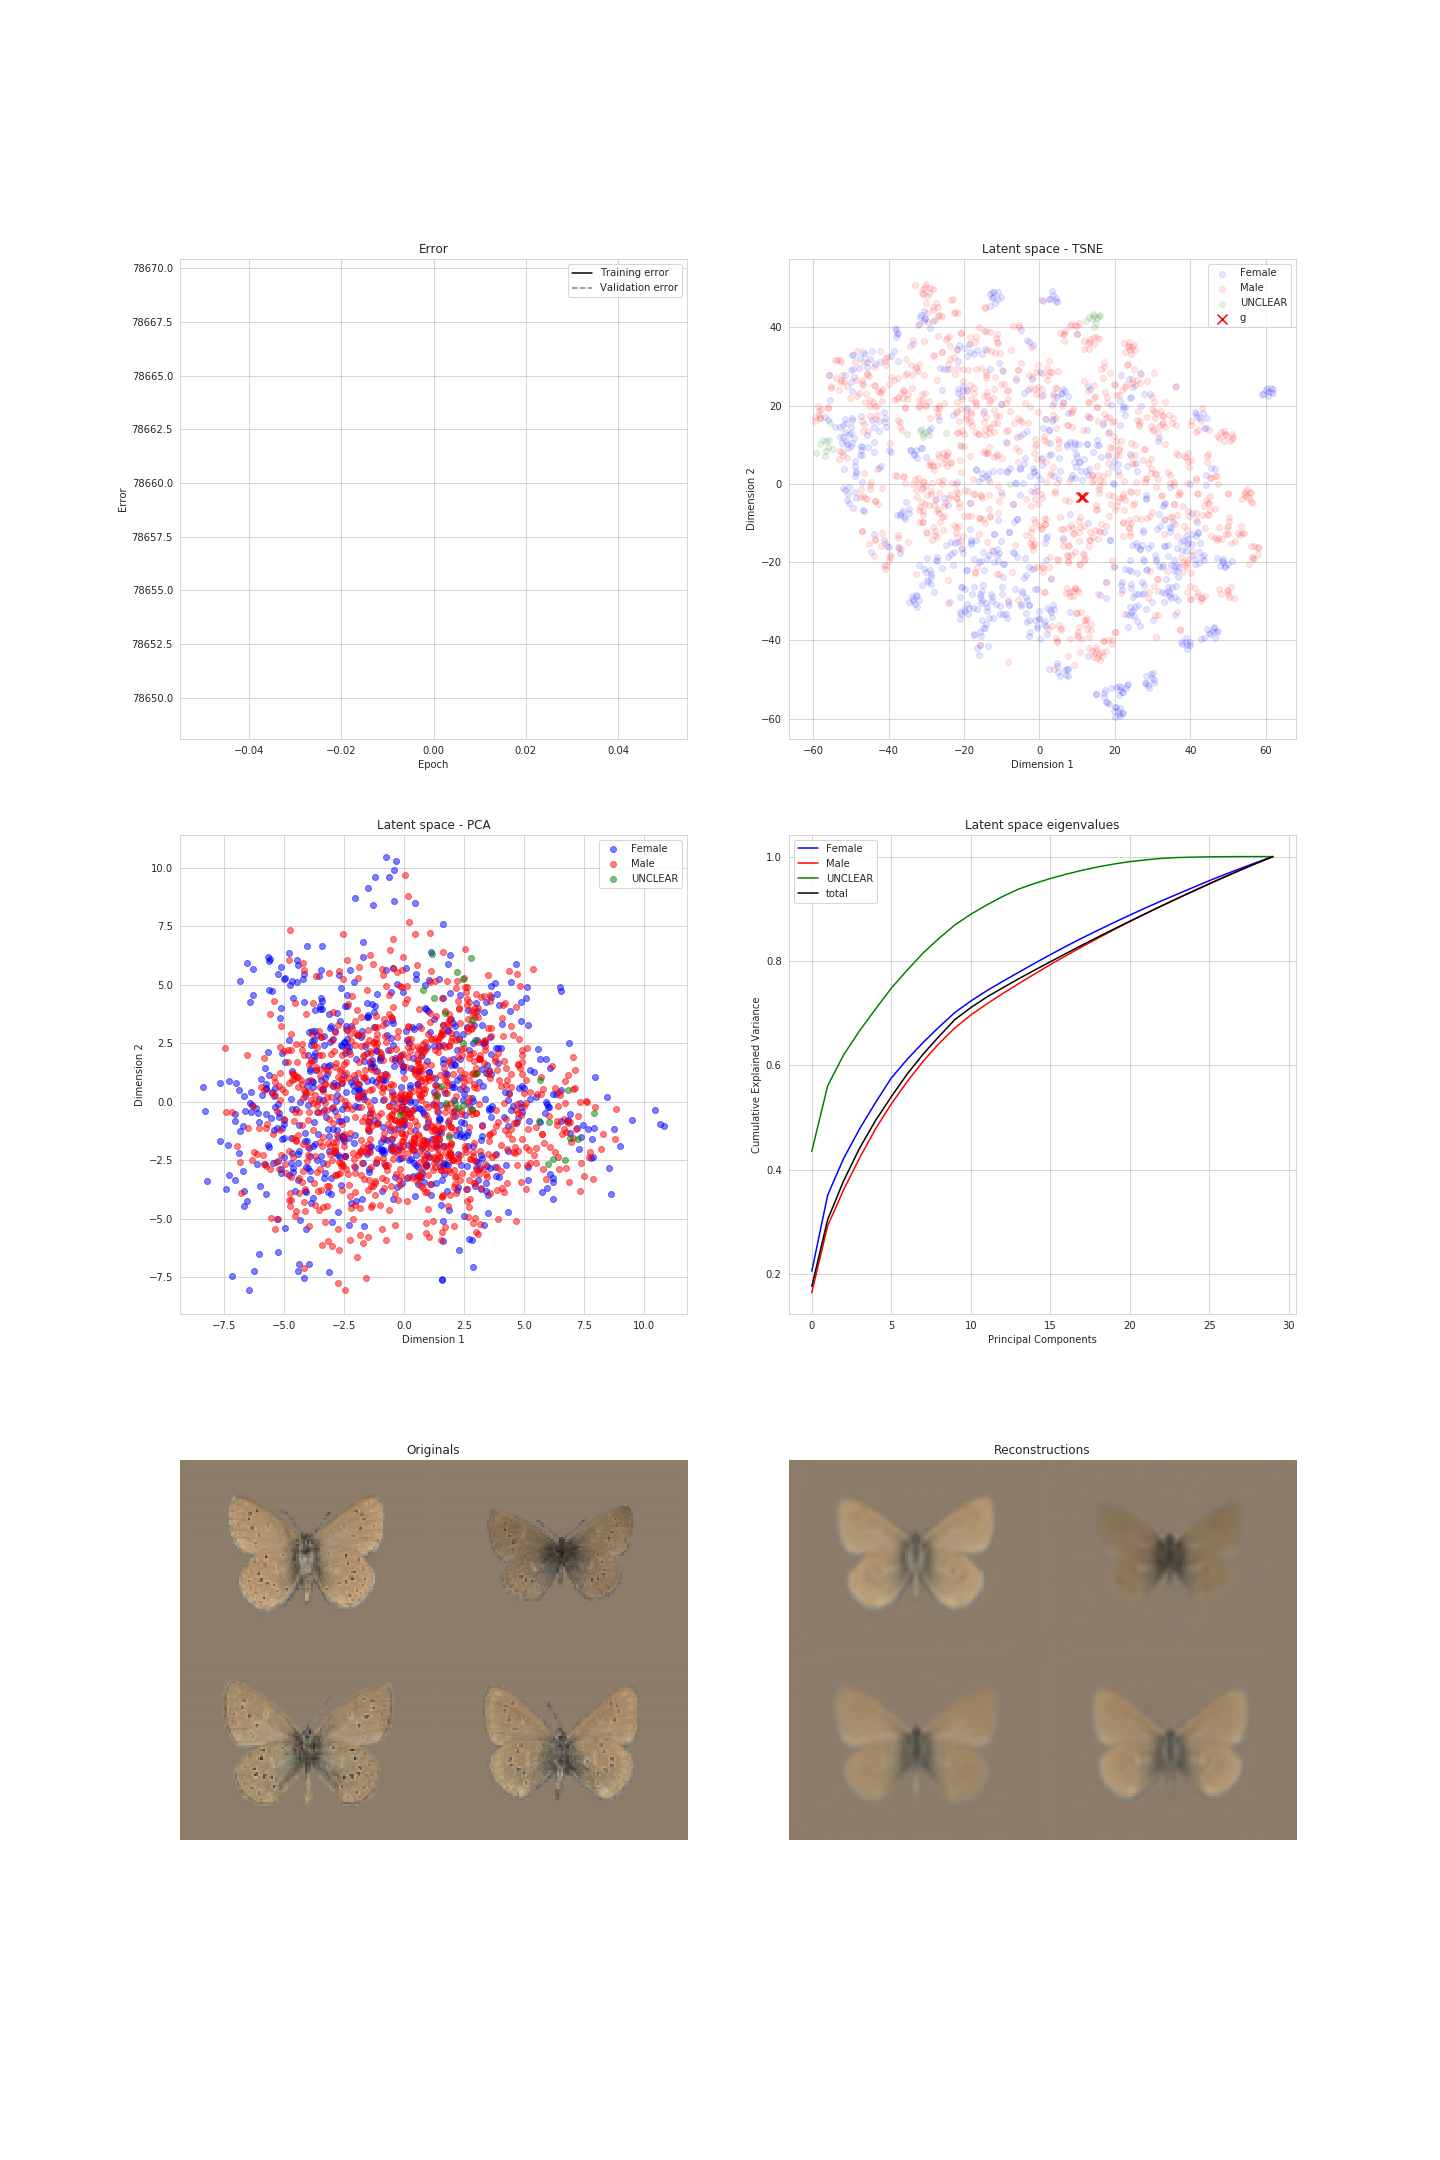

In [5]:
ex.max_num_epochs = 1
ex.run_experiment()

In [4]:
ex.outputs_example['x'][0].unsqueeze(0).shape

torch.Size([1, 6, 160, 240])

RuntimeError: size mismatch, m1: [256 x 3], m2: [768 x 500] at /opt/conda/conda-bld/pytorch_1549636813070/work/aten/src/TH/generic/THTensorMath.cpp:940

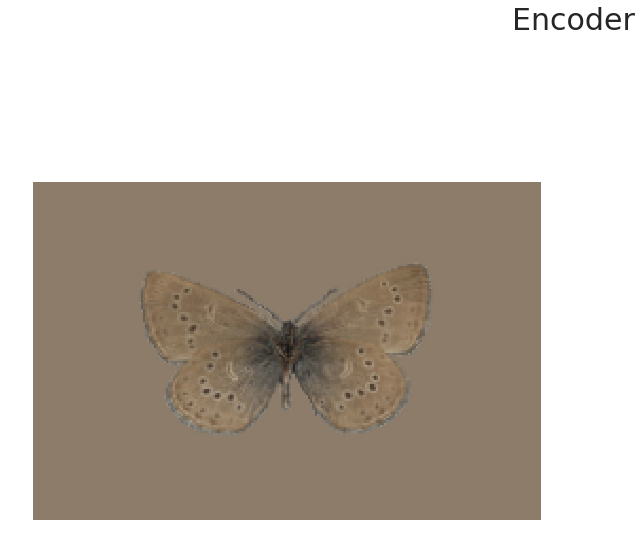

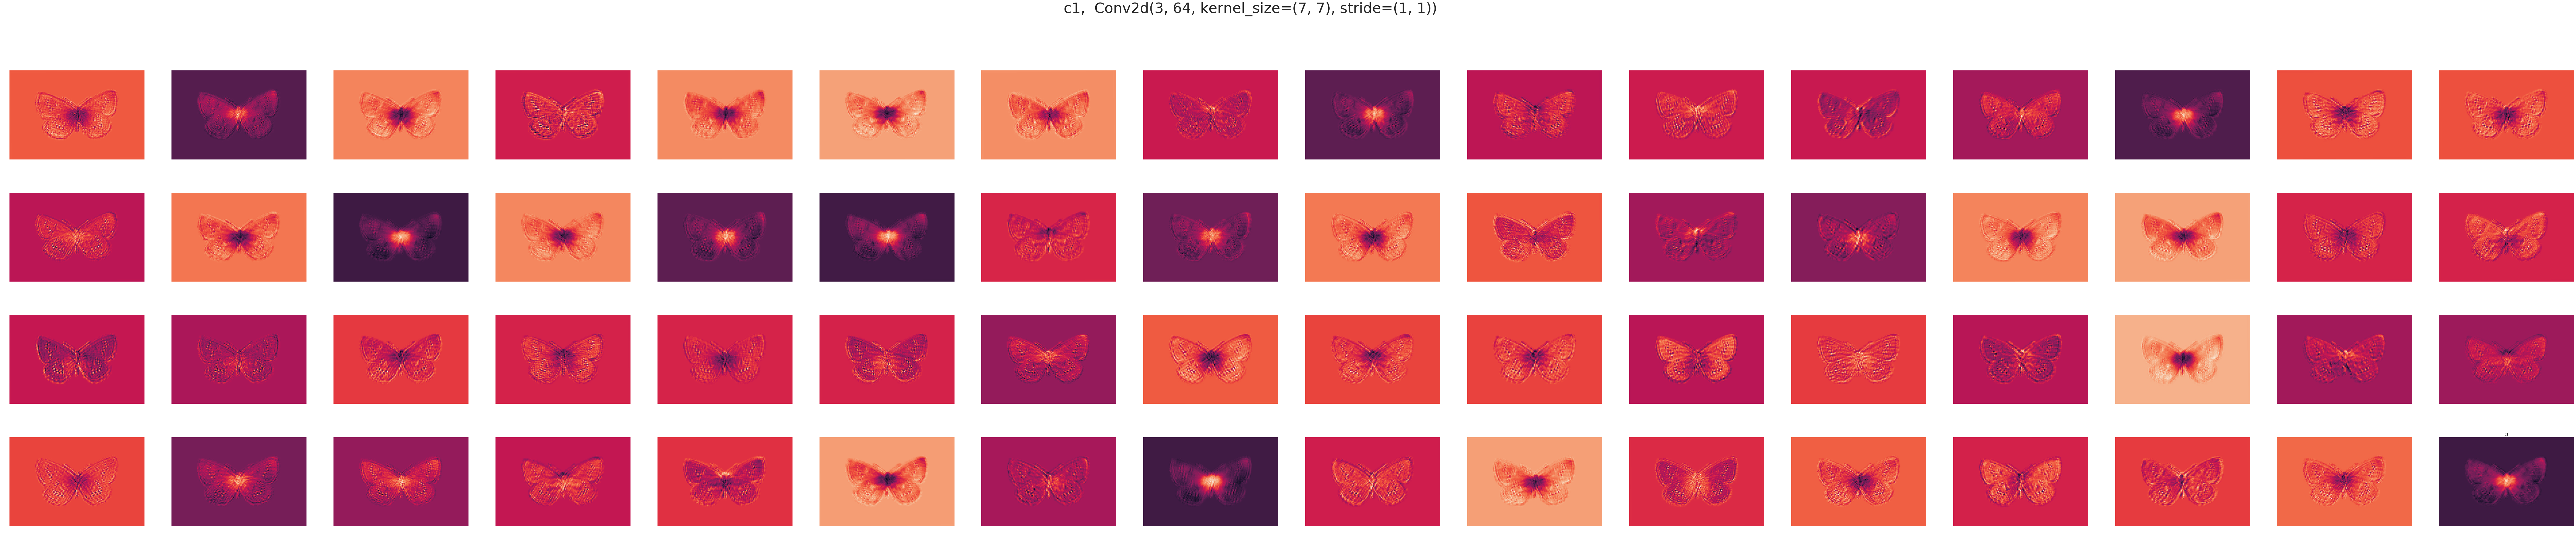

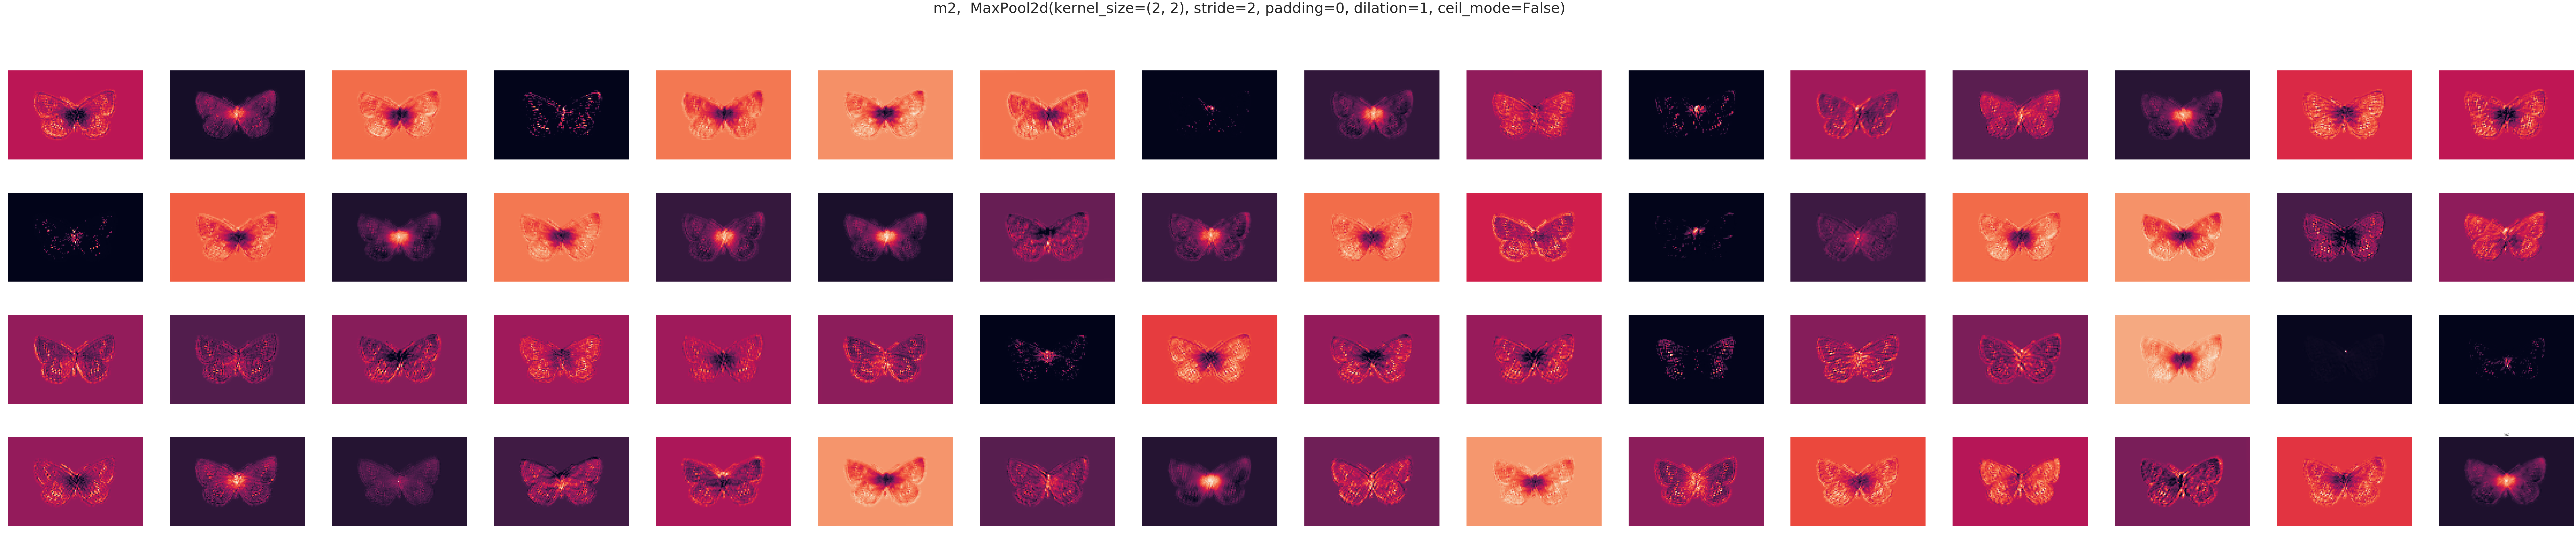

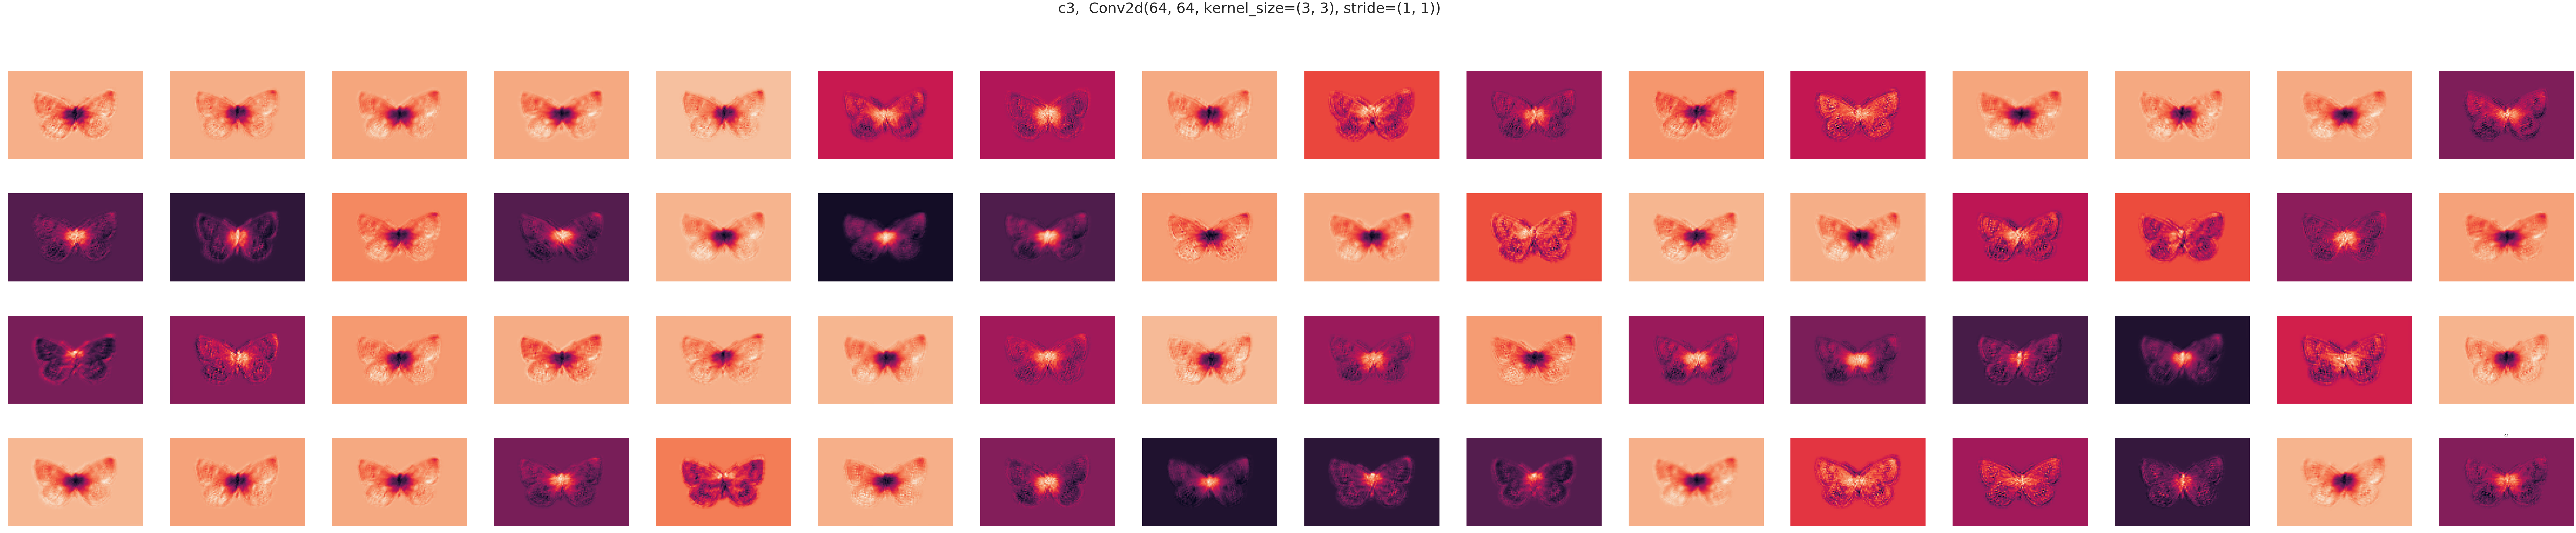

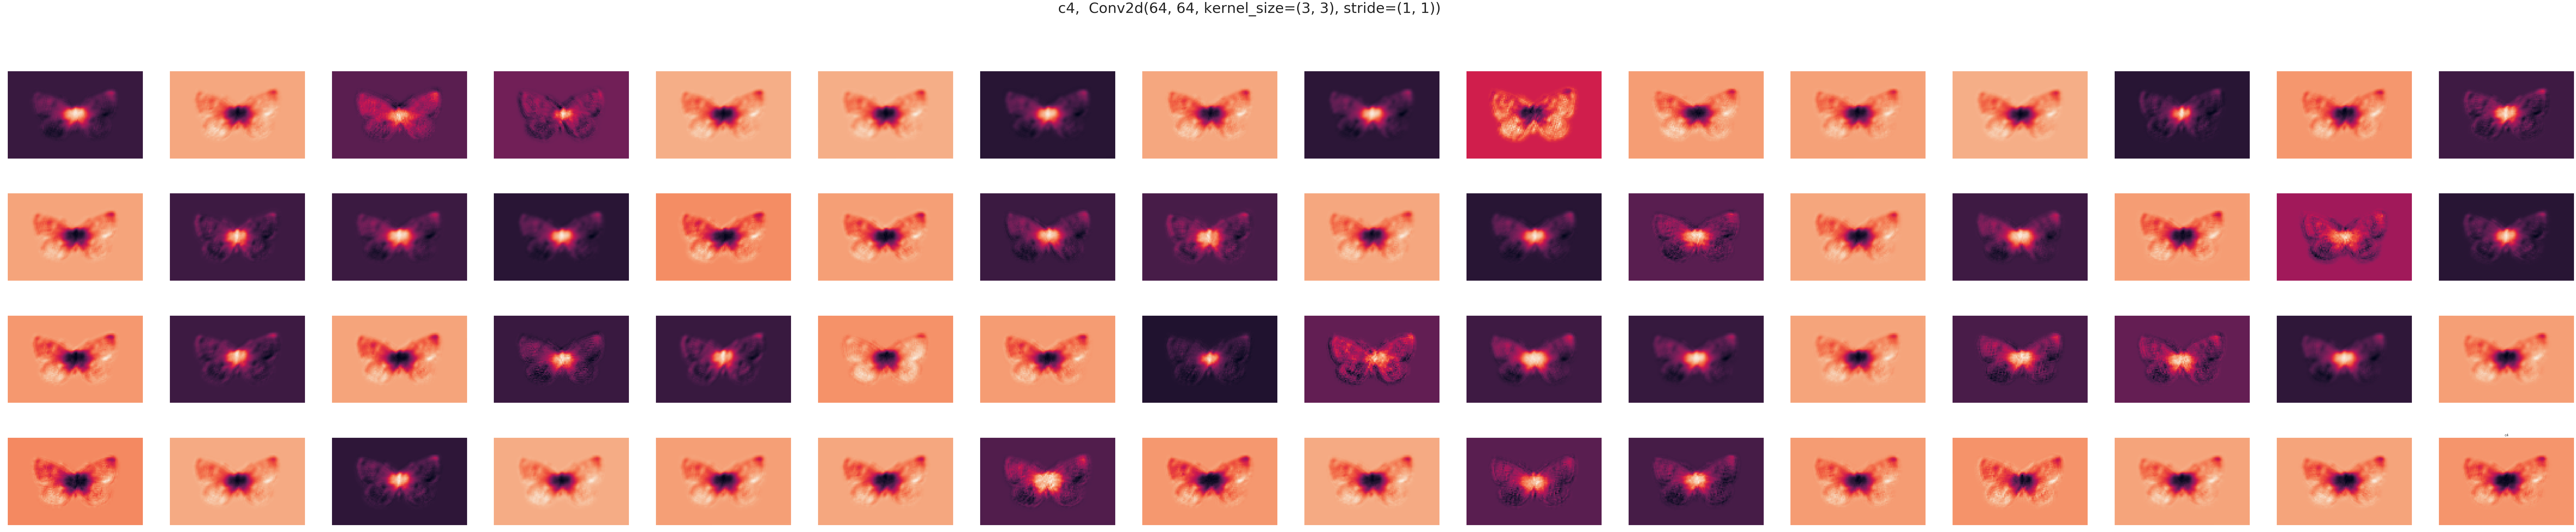

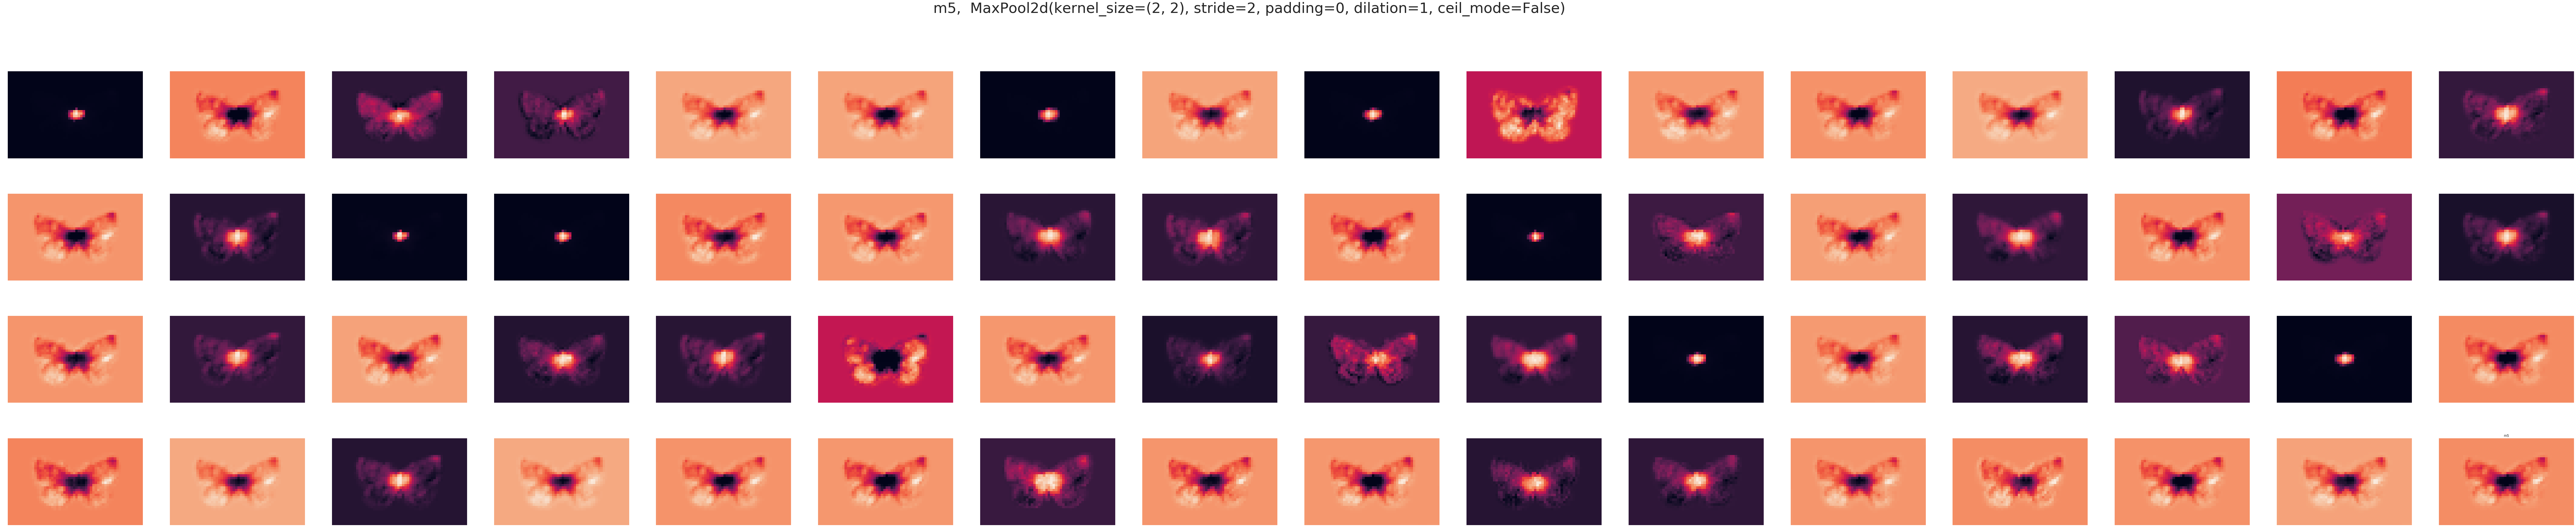

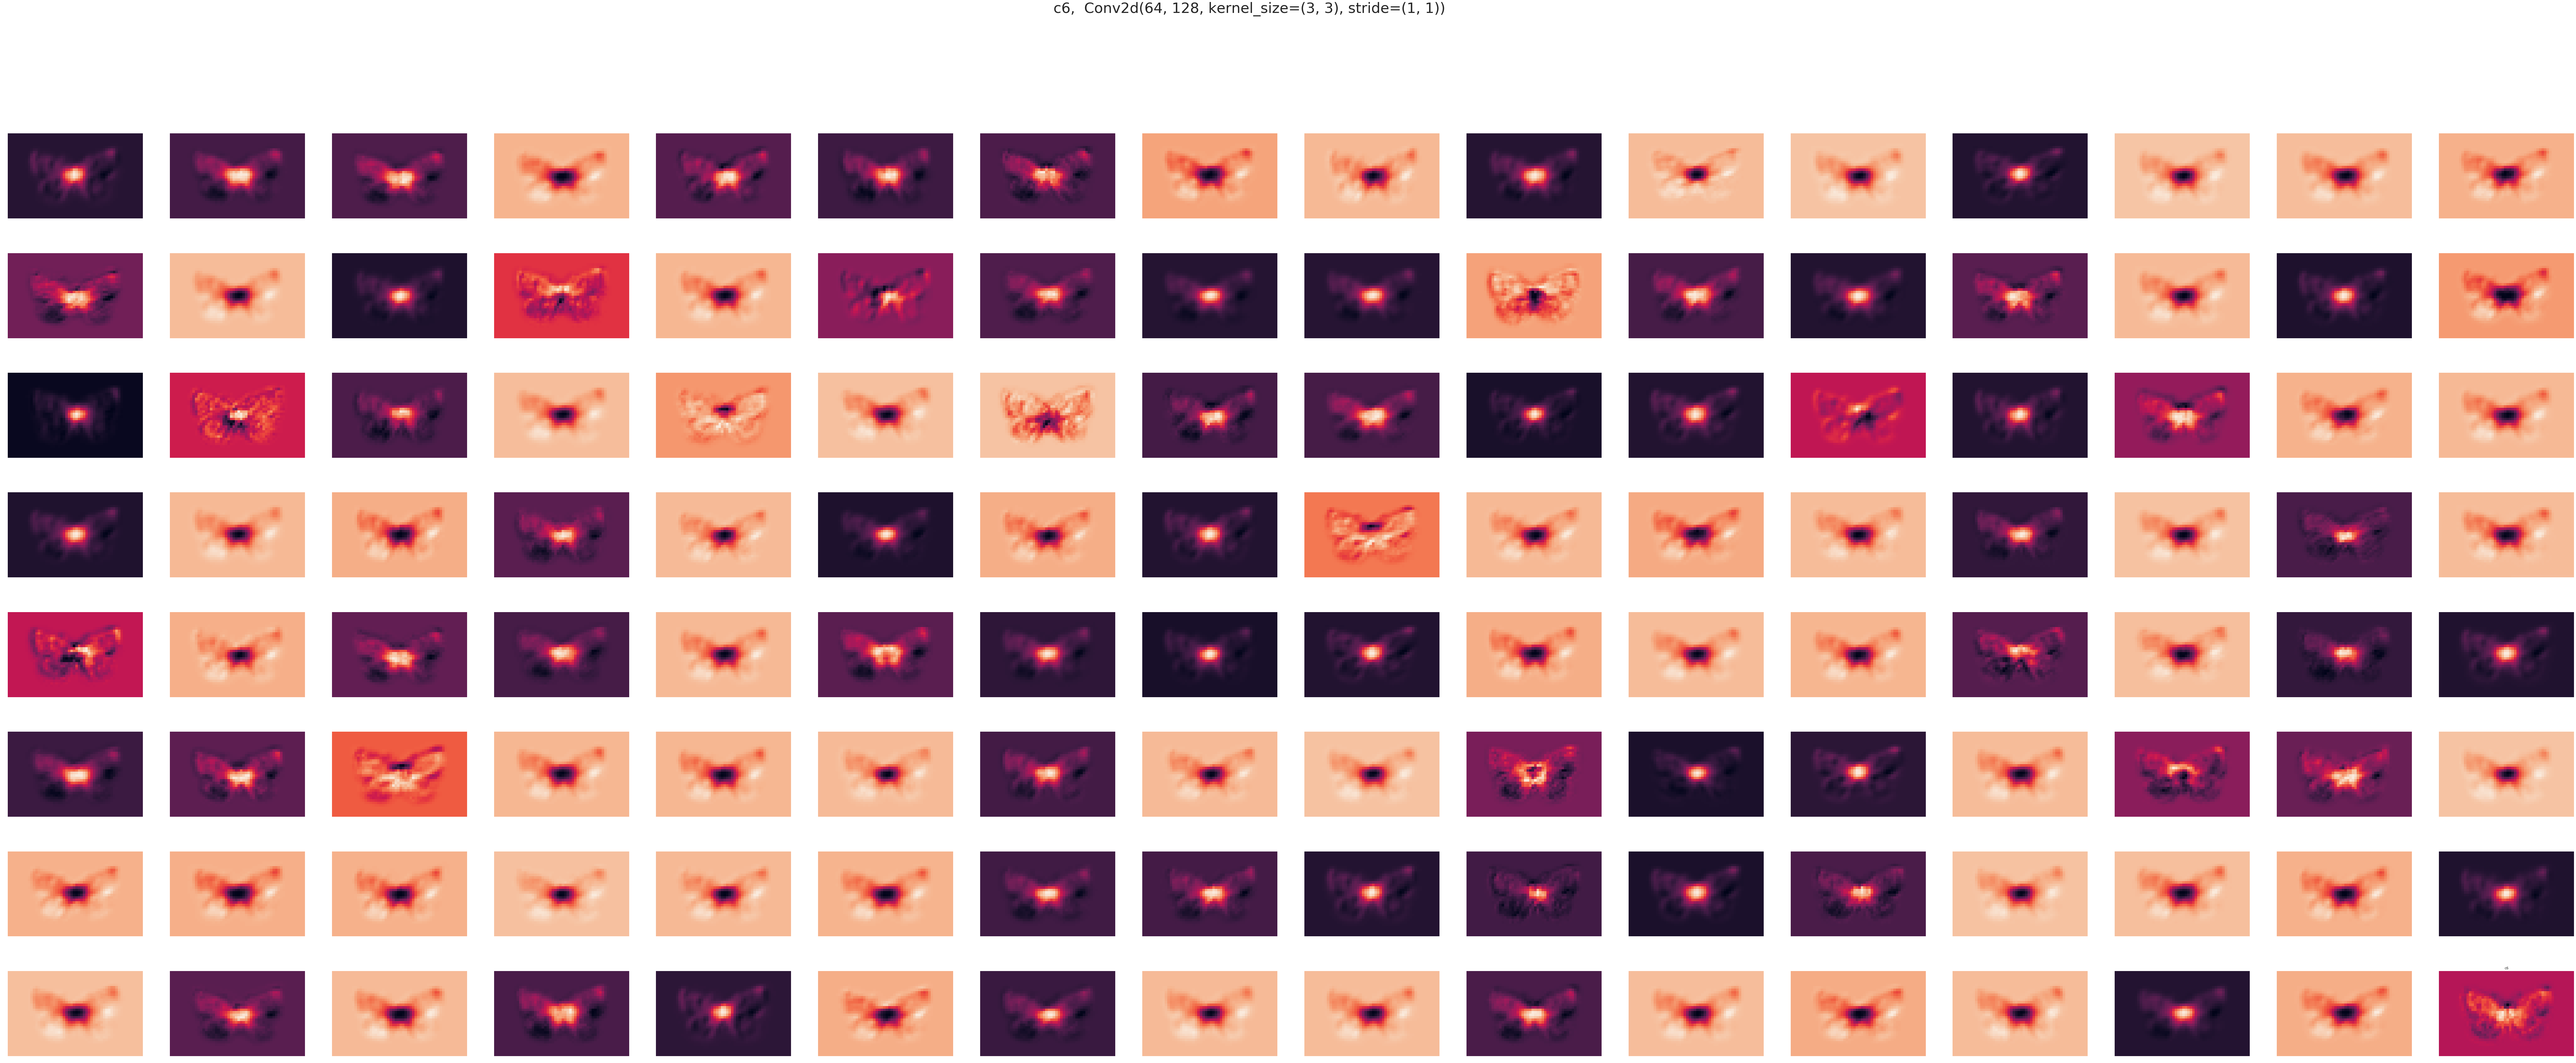

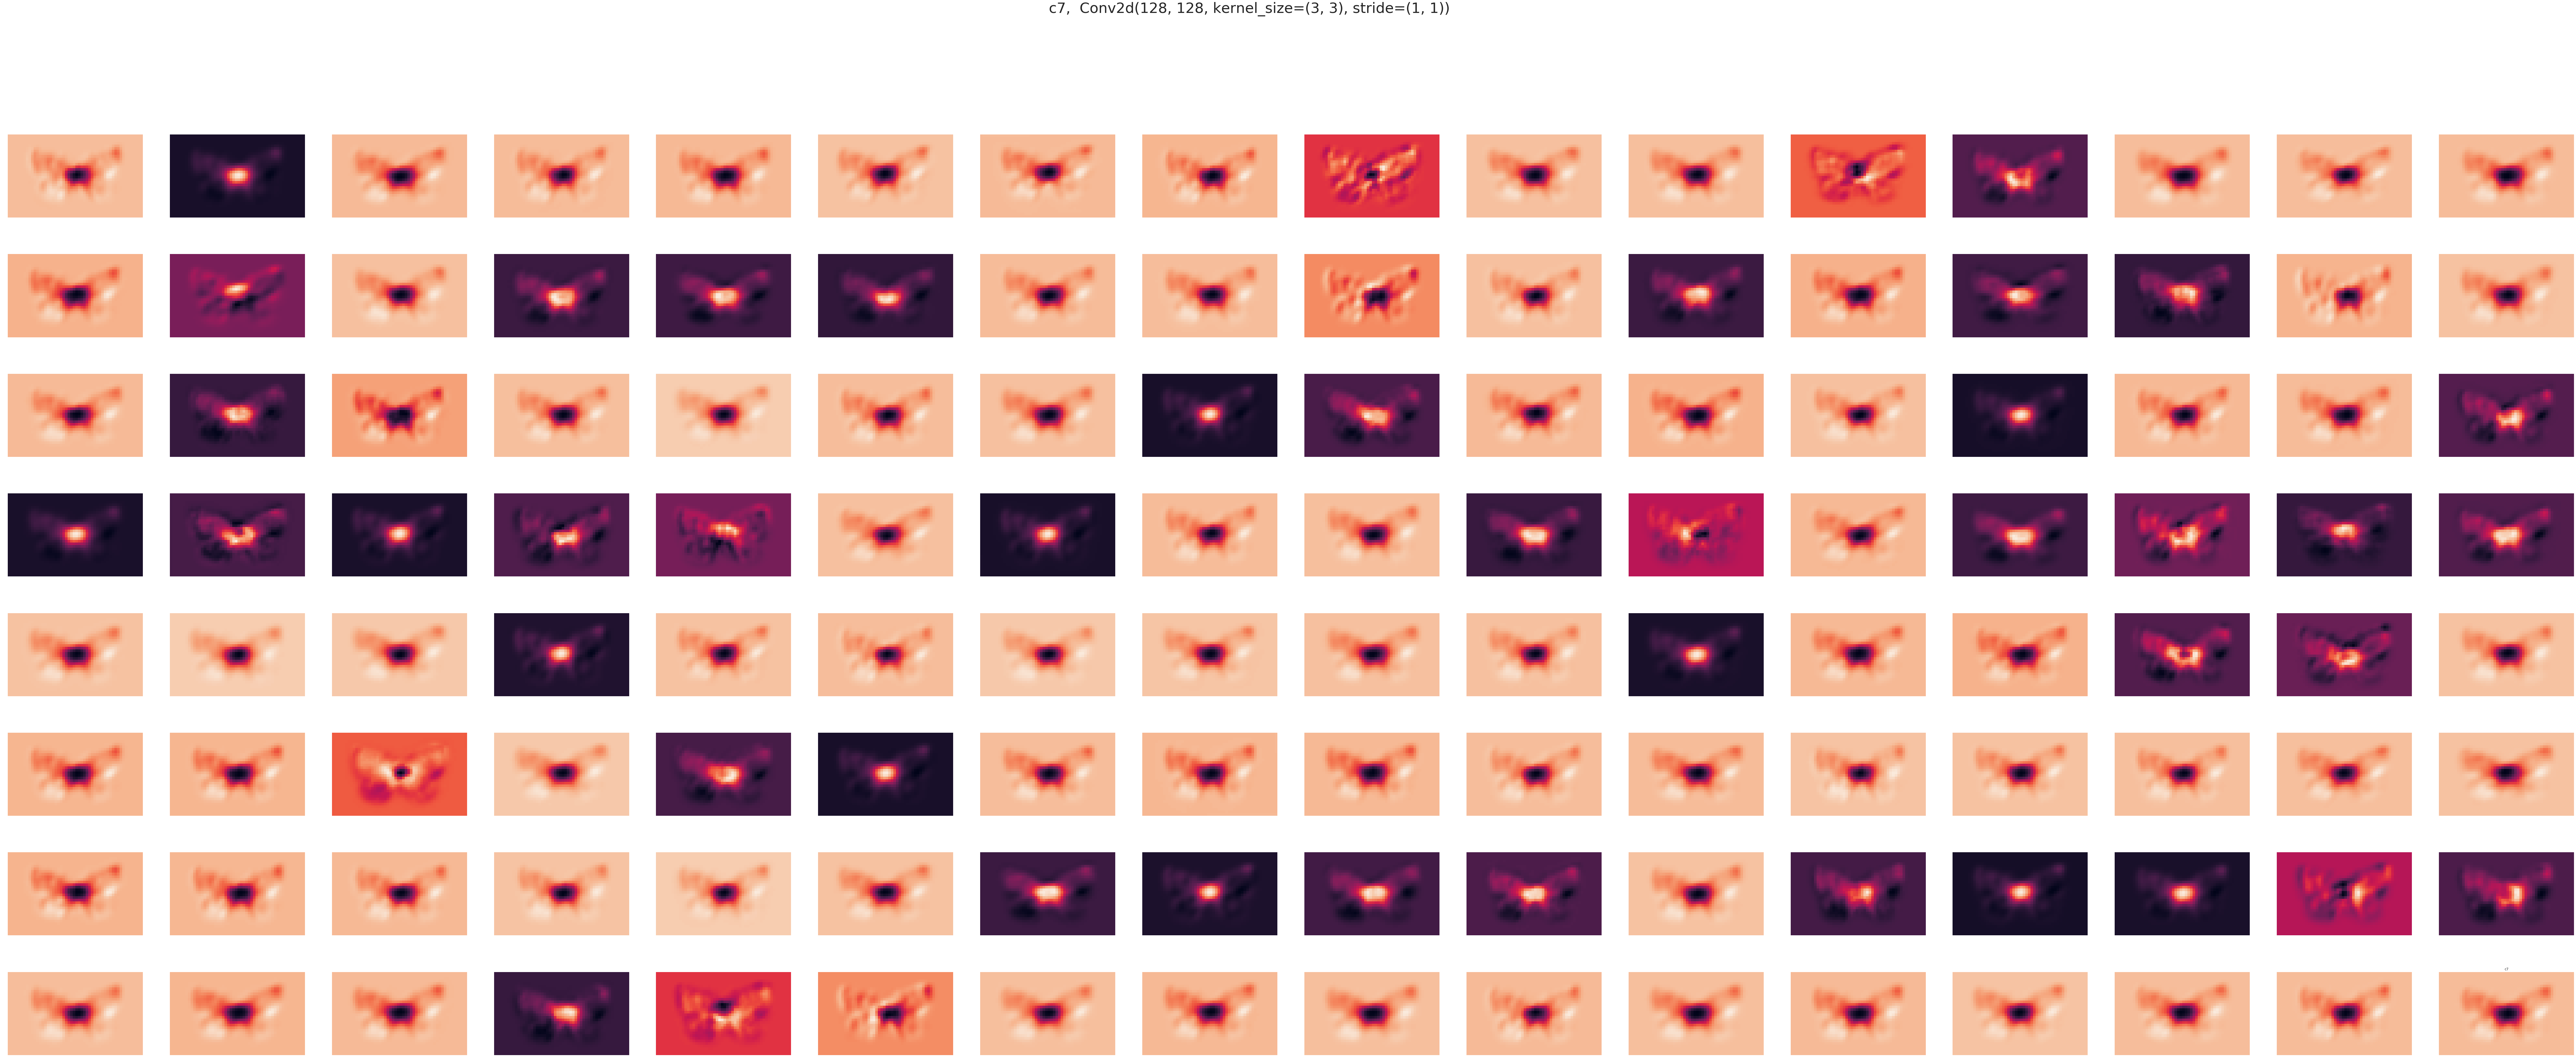

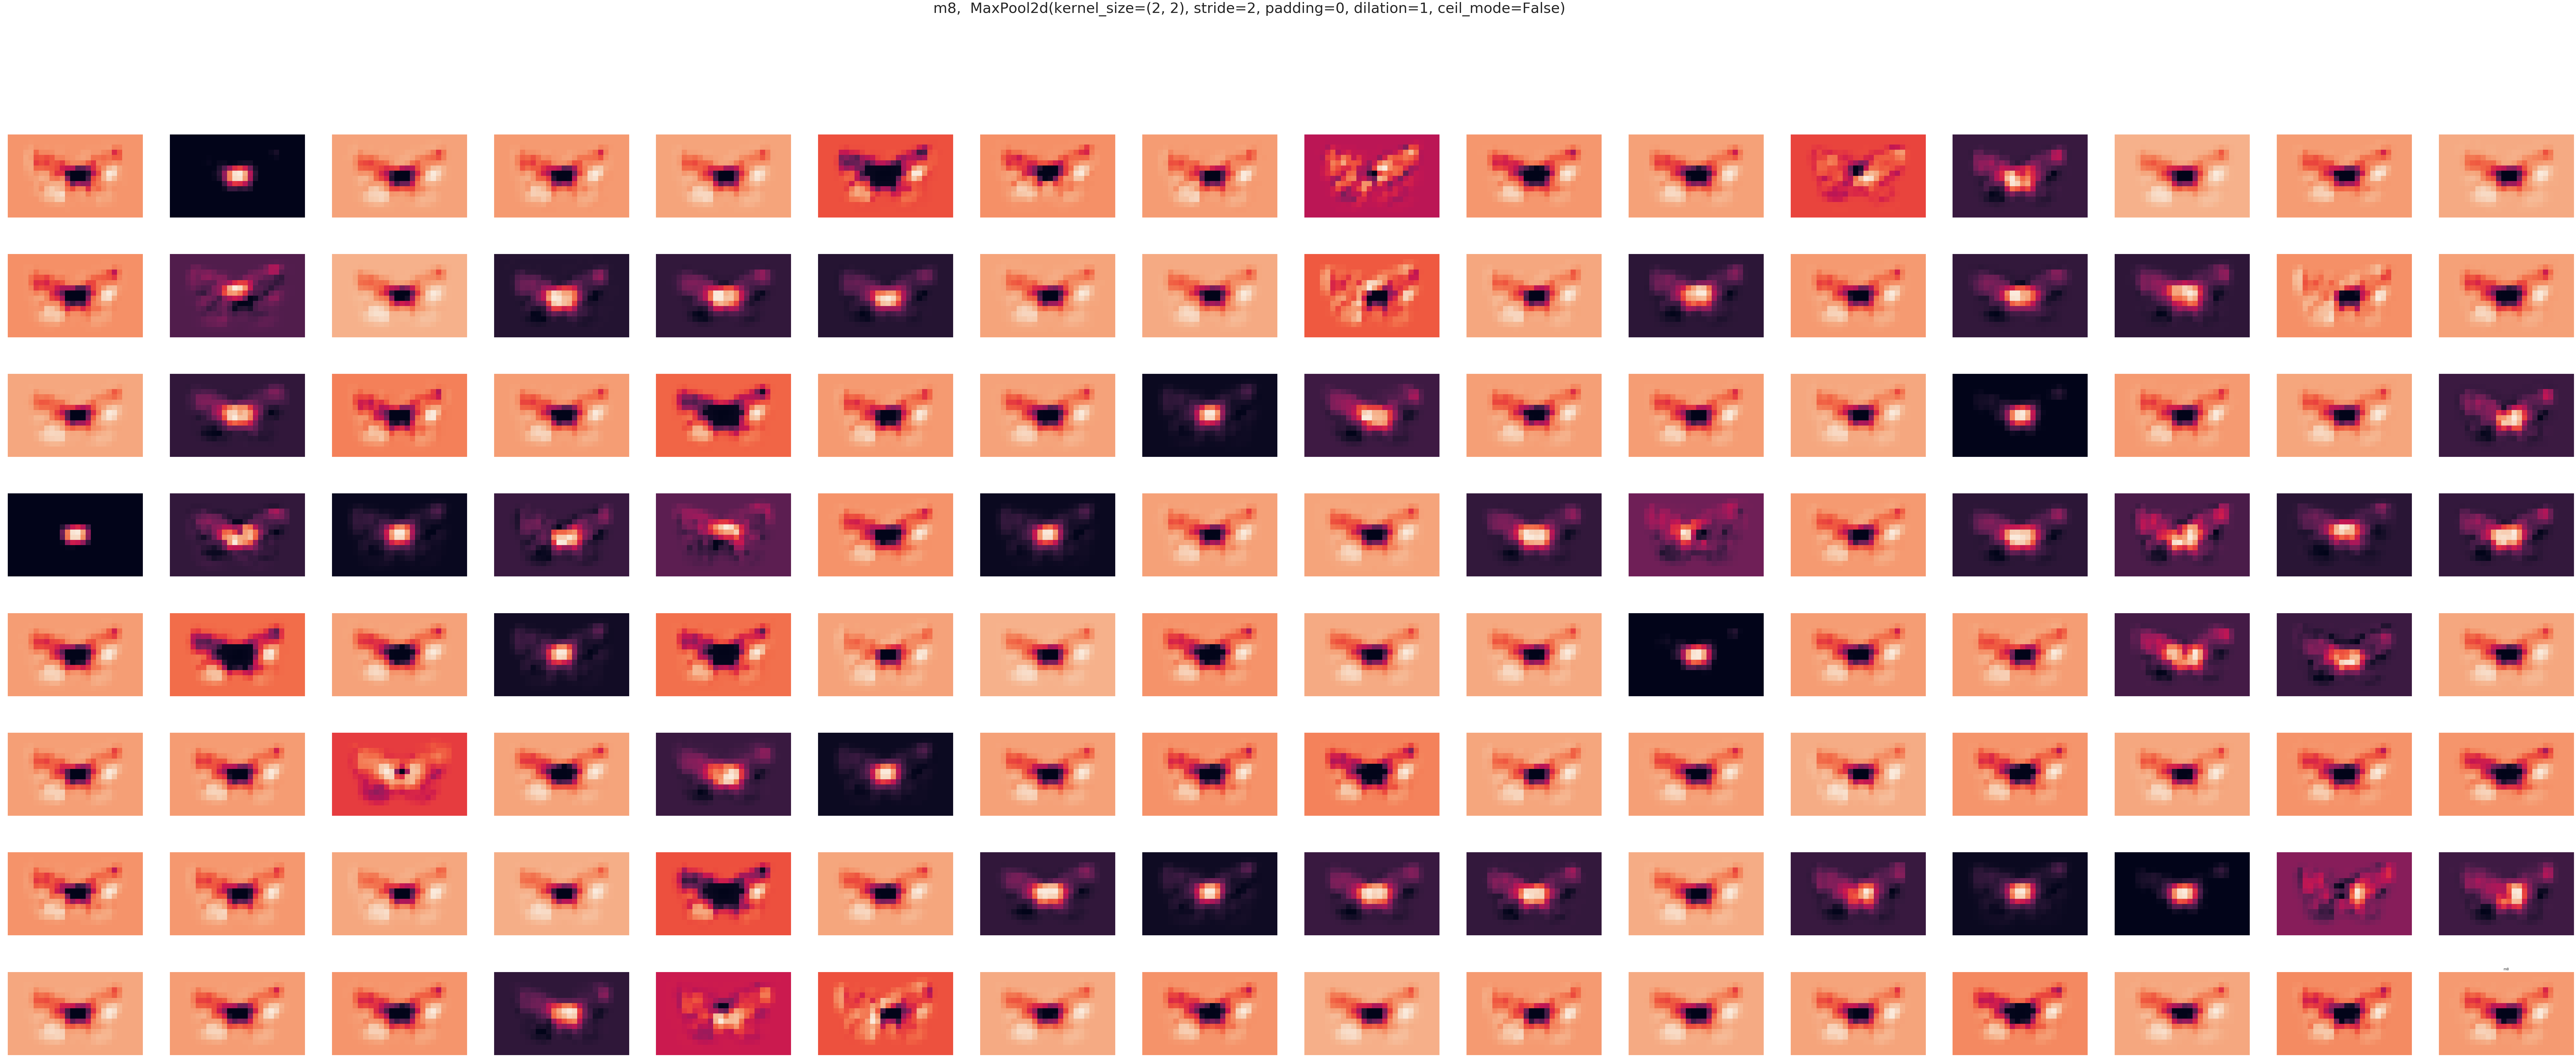

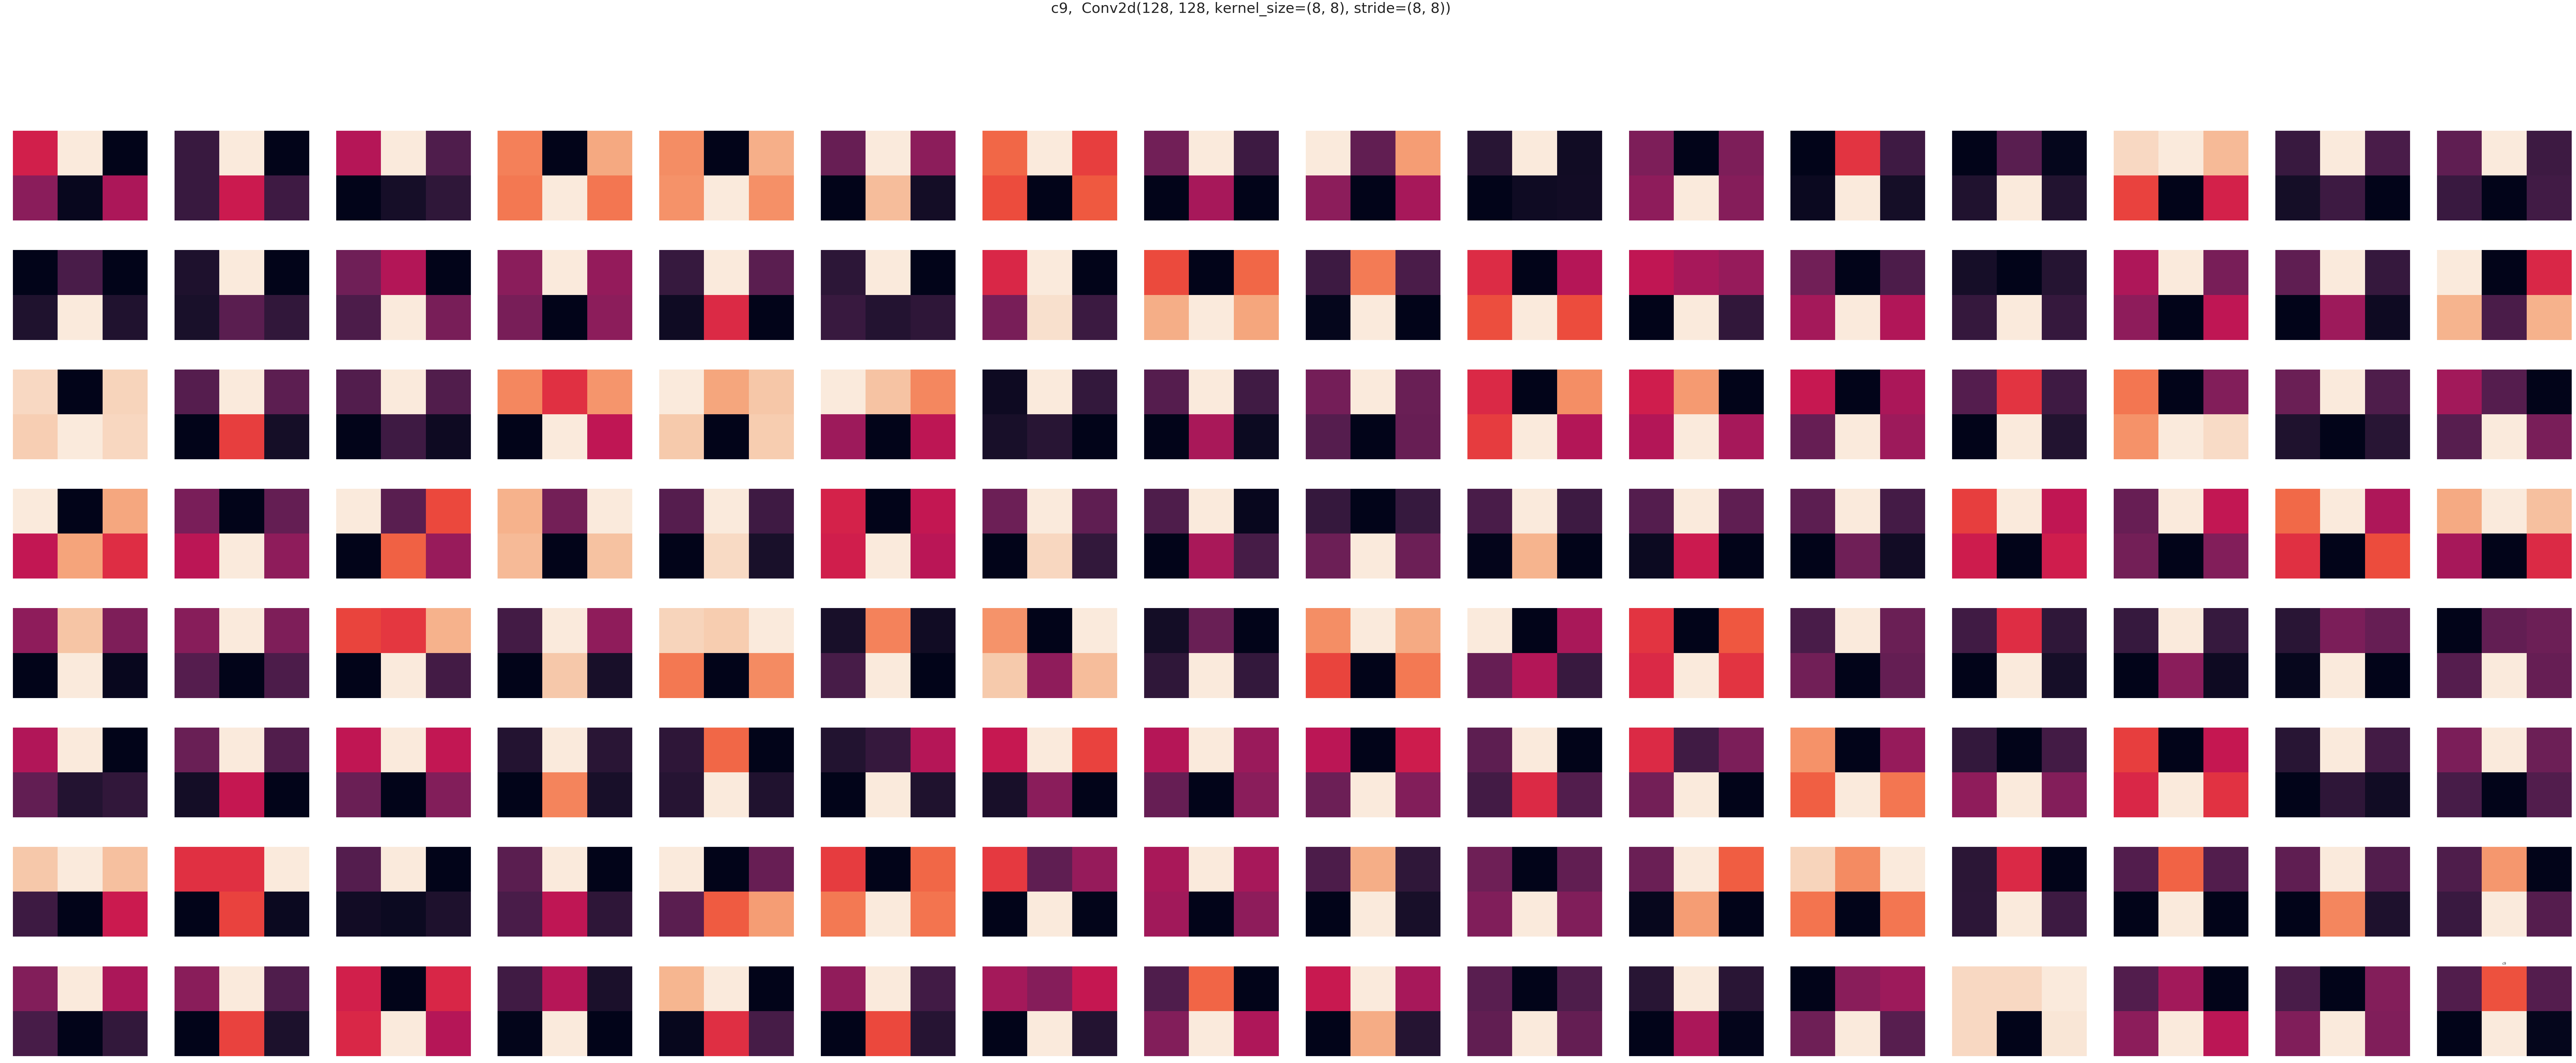

In [10]:
x = ex.outputs_example['x'][2].unsqueeze(0).cpu()
fig = plt.figure(figsize=(20,10))
fig.suptitle("Encoder", fontsize=30)
plt.subplot(1,2,1)
plt.imshow(x[0,:3].detach().numpy().swapaxes(0,2).swapaxes(0,1))
plt.axis('off')
plt.grid(b=None)
#plt.subplot(1,2,2)
#plt.imshow(x[0,3:].detach().numpy().swapaxes(0,2).swapaxes(0,1))
#plt.axis('off')
#plt.grid(b=None)

plot_no = 1
for layer in ex.net.encoder._modules:
    
    exec(f"x = ex.net.encoder.{layer}(x)")
    exec(f"{layer} = x.clone()")
    
    if 'c' or 'm' in layer:
        
        n_responses = x.shape[1]
        n_cols = 16
        n_rows = n_responses/n_cols
        fig_height = 30 if n_responses == 64 else 60
        fig = plt.figure(figsize=(160,fig_height))
        fig.tight_layout()
        exec(f"fig.suptitle(layer + ',  ' + str(ex.net.encoder.{layer}), fontsize=50)")
        for i in range(1,n_responses+1):
            
            plt.subplot(n_rows, n_cols, i)
            plt.imshow(x[0,i-1].detach().numpy())
            plt.axis('off')
            plt.grid(b=None)
        
        plt.title(layer)
        plt.savefig('V_encoder_%s.jpg'%plot_no)
        plot_no += 1
    #if 'm' in layer:
    #    break
        
        
    exec(f"x = F.leaky_relu(x)")
        
    

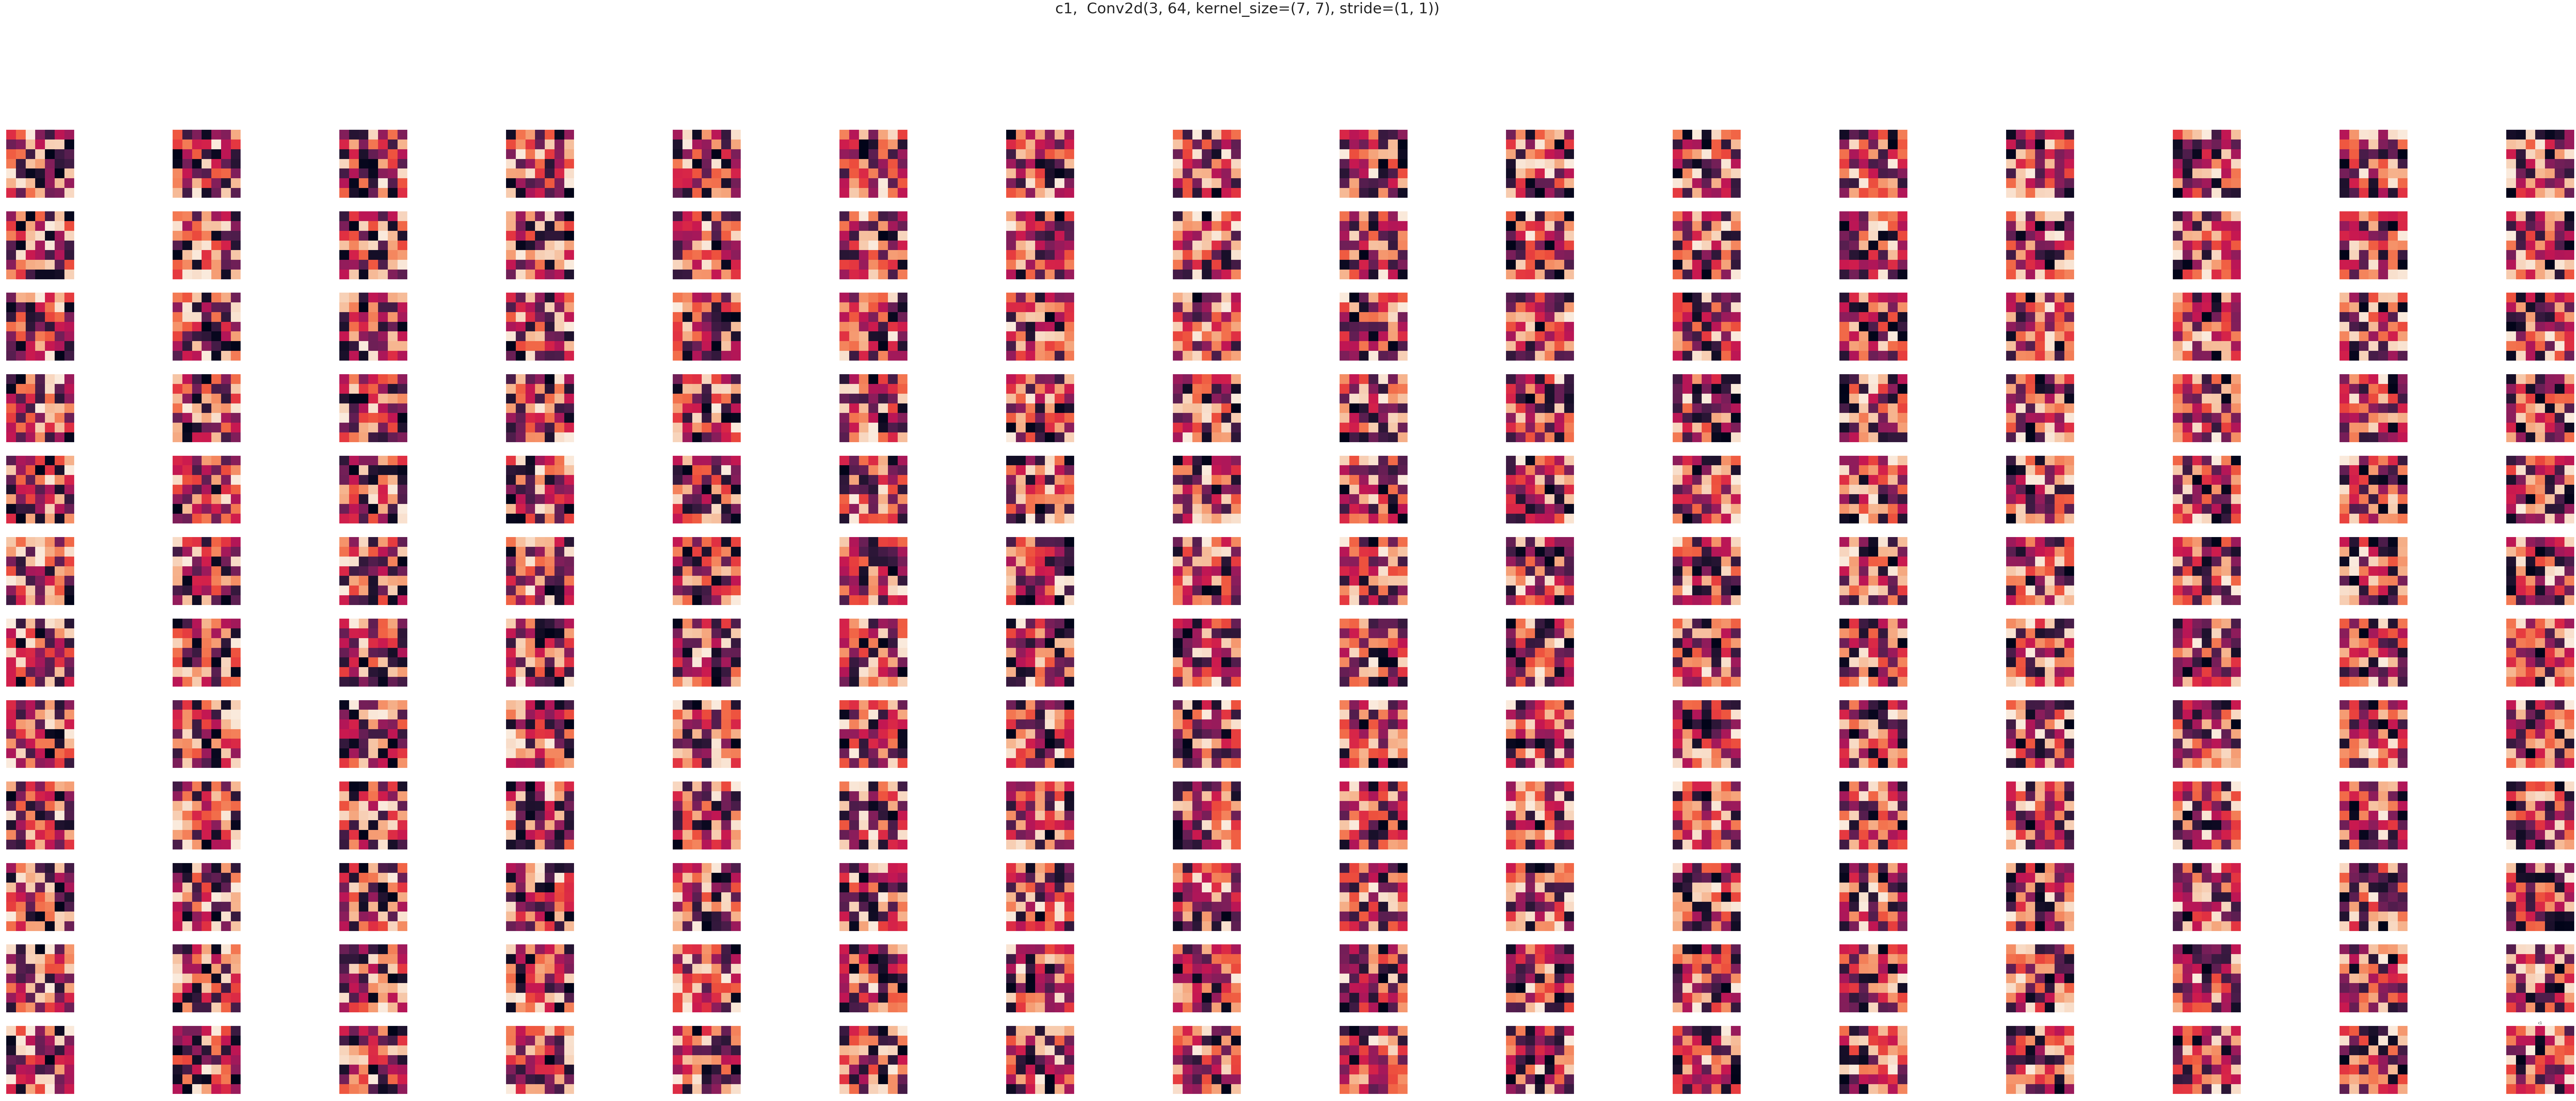

In [14]:

#fig = plt.figure(figsize=(20,10))
#fig.suptitle("Encoder", fontsize=30)
#plt.subplot(1,2,1)
#plt.imshow(x[0,:3].detach().numpy().swapaxes(0,2).swapaxes(0,1))
#plt.axis('off')
#plt.grid(b=None)
#plt.subplot(1,2,2)
#plt.imshow(x[0,3:].detach().numpy().swapaxes(0,2).swapaxes(0,1))
#plt.axis('off')
#plt.grid(b=None)

plot_no = 1
for layer in ex.net.encoder._modules:
    
    if 'c' in layer:
        exec(f"weights = ex.net.encoder.{layer}._parameters['weight']")
        n = weights.shape[1]
        m = weights.shape[0]
        n_responses = n*m
        n_cols = 16
        n_rows = n_responses/n_cols
        fig_height = 30 if n_responses == 64 else 60
        fig = plt.figure(figsize=(160,fig_height))
        fig.tight_layout()
        exec(f"fig.suptitle(layer + ',  ' + str(ex.net.encoder.{layer}), fontsize=50)")
        for i in range(0,m):
            for j in range(1,n+1):
                sp = i*n + j
                plt.subplot(n_rows, n_cols, sp)
                plt.imshow(weights[i-1][j-1].cpu().detach().numpy())#.swapaxes(0,2))
                plt.axis('off')
                plt.grid(b=None)
        
        plt.title(layer)
        #plt.savefig('V_encoder_%s.jpg'%plot_no)
        plot_no += 1
        break

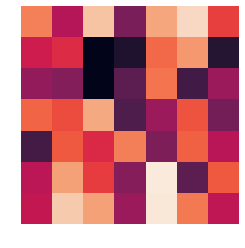

In [39]:
a = weights[0][2].detach().numpy()#.swapaxes(0,2)
plt.imshow((a - a.min())/(a.max()-a.min()))

plt.axis('off')
plt.grid(b=None)

In [11]:
ex.net.encoder.c3._parameters['weight']

Parameter containing:
tensor([[[[ 3.2977e-02, -2.6724e-02,  7.6318e-03],
          [-1.9186e-02, -2.0929e-02,  2.2149e-02],
          [-9.9867e-03,  3.3666e-02,  3.7252e-02]],

         [[-3.3733e-02,  1.7797e-02, -3.4956e-02],
          [ 9.3796e-04,  3.2545e-02,  9.4839e-03],
          [ 3.1529e-02, -3.8351e-02,  2.2944e-02]],

         [[ 2.6929e-02,  4.2001e-02,  4.2755e-02],
          [ 2.2381e-03,  2.2917e-02, -4.2685e-03],
          [ 1.1261e-02,  1.4597e-03, -6.9862e-03]],

         ...,

         [[ 1.8591e-02,  3.0274e-02,  2.3986e-02],
          [-1.5074e-02,  3.1176e-02, -2.2838e-02],
          [ 5.1389e-02, -1.4276e-02, -2.9254e-02]],

         [[ 1.1733e-02,  1.8976e-03, -3.2492e-02],
          [-3.2664e-02, -2.8427e-02,  3.8213e-02],
          [-3.0750e-02,  1.8868e-02,  1.4215e-02]],

         [[-8.5078e-03,  3.1259e-02,  1.7271e-02],
          [ 2.2091e-02, -3.1285e-02, -4.1295e-02],
          [-2.7516e-02, -1.6711e-02, -7.8946e-03]]],


        [[[-3.2312e-02, -1.5274

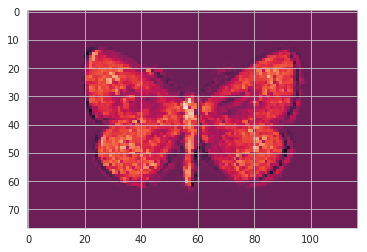

In [34]:
plt.imshow(F._max_pool2d(c1, (2,2), stride=2)[0][33].cpu().detach())

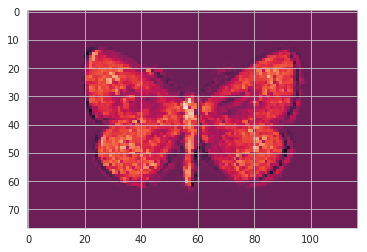

In [37]:
plt.imshow(ex.net.encoder.m2(F.leaky_relu(c1))[0][33].detach())

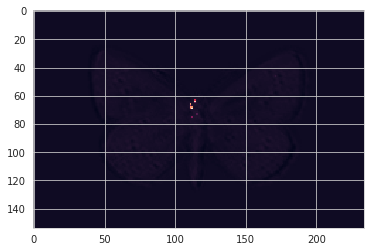

In [46]:
plt.imshow(F.leaky_relu(c1)[0][33].detach())#F.leaky_relu(c1)[0][33]

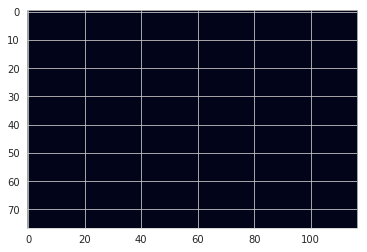

In [15]:
plt.imshow(x[0][0].cpu().detach())

In [18]:
x[0][0].min()

tensor(0., grad_fn=<MinBackward1>)

In [ ]:
x = ex.outputs_example['x'][0].unsqueeze(0).cpu()
_, encoder_sizes = ex.net.encoder(x)
z = ex.outputs_example['decoder_z'][0].unsqueeze(0).cpu()
z = ex.net.decoder.l11(z)
z = ex.net.decoder.l10(F.relu(z))
pre_flatten_size = torch.Size((z.size()[0],ex.net.decoder.pre_flatten_size[1],ex.net.decoder.pre_flatten_size[2],ex.net.decoder.pre_flatten_size[3]))
z = z.view(pre_flatten_size)
#x = self.c9(F.relu(x))

fig = plt.figure(figsize=(2,1))
fig.suptitle("decoder", fontsize=30)

plot_no = 1
interpolation_no = 2
for layer in ex.net.decoder._modules:
    
    
    if 'c' in layer:
        
        exec(f"z = ex.net.decoder.{layer}(z)")
        n_responses = z.shape[1]
        n_cols = 16
        n_rows = n_responses/n_cols
        fig_height = 30 if n_responses == 64 else 60
        fig = plt.figure(figsize=(160,fig_height))
        fig.tight_layout()
        exec(f"fig.suptitle(layer + ',  ' + str(ex.net.encoder.{layer}), fontsize=50)")
        for i in range(1,n_responses+1):
            
            plt.subplot(n_rows, n_cols, i)
            plt.imshow(z[0,i-1].detach().numpy())
            plt.axis('off')
            plt.grid(b=None)
        
        plt.title(layer)
        plt.savefig('decoder_%s.jpg'%plot_no)
        plot_no += 1
        exec(f"z = F.relu(z)")
        break
    elif 'm' in layer:
        exec(f"z = F.interpolate(F.relu(z),size=encoder_sizes[{interpolate_no}][2:])")
        interpolation_no -= 1 
        n_responses = z.shape[1]
        n_cols = 16
        n_rows = n_responses/n_cols
        fig_height = 30 if n_responses == 64 else 60
        fig = plt.figure(figsize=(160,fig_height))
        fig.tight_layout()
        exec(f"fig.suptitle('Interpolate {interpolate_no}', fontsize=50)")
        for i in range(1,n_responses+1):
            
            plt.subplot(n_rows, n_cols, i)
            plt.imshow(z[0,i-1].detach().numpy())
            plt.axis('off')
            plt.grid(b=None)
        
        plt.title(layer)
        plt.savefig('decoder_%s.jpg'%plot_no)
        plot_no += 1
        break
        
    

In [7]:
z.shape

torch.Size([1, 128, 2, 3])